In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch_scatter import scatter_max, scatter_mean
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import re
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
folder_path = r'C:\Users\fardin\Projects\CGNet\Data\TextClassification\IMDB'
# t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
token_vocab_dict = dict(zip(all_vocab_str, embeddings))

with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)
polarities_subjectivities.shape
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [3]:
keep_ratio = 0.1
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
test_df['Content'] = test_df['text']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.DataFrame(np.concatenate([train_df.values, test_df.values]), columns=train_df.columns)
class_id = {c:i for i, c in enumerate(sst_classes)}
id_class = {i:c for i, c in enumerate(sst_classes)}
df.shape

(5000, 2)

In [4]:
# %%time
vocabs_lists = list(token_vocab_dict.keys())
term_frequencies = {t:1 for t in vocabs_lists}
temp_term_frequencies = {}

for doc in train_df.Content.values:
    tokens_list = tokenizer.tokenize(doc)
    new_tokens = {t.strip('▁').lower() for t in tokens_list}
    for t in new_tokens:
        if t not in temp_term_frequencies:
            temp_term_frequencies[t] = 0
        temp_term_frequencies[t] += 1
        
for k, v in term_frequencies.items():
    stripped_token = k.strip('▁').lower()
    term_frequencies[k] = temp_term_frequencies[stripped_token] if stripped_token in temp_term_frequencies else 1


In [5]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x

In [6]:
from utilities.data_manager.CharacterandTokenLevelCustomDataset import CharacterandTokenLevelCustomDataset
from utilities.data_manager.CharacterandTokenLevelDataLoader import CharacterandTokenLevelDataLoader

In [7]:
%%time
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, id_class=id_class, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, id_class=id_class, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

100%|██████████| 2560/2560 [00:34<00:00, 74.43it/s]

CPU times: total: 4min 34s
Wall time: 1min 9s


In [8]:
X, y = next(iter(test_dataloader))

In [9]:
from utilities.model_layers.GCNN import GCNN
# from utilities.model_layers.GenGraph import GenGraph
from utilities.model_layers.SentimentInjection import SentimentInjection

In [1]:
from torch import nn
import torch
from torch_geometric.data import Batch, Data

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, head=4, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head = head
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_counts*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_indices = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_counts )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_counts, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_indices[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_indices[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
        
    def re_gen_graph(self, x, edge_indices, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_indices[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_indices, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_counts*self.virtual_nodes
        # if v_n_e_counts>0:
        #     important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        # else:
        #     print(f'edge_weights.shape: {edge_weights.shape}')
        #     print(f'total_token_coutns: {total_token_coutns}')
        #     print(f'p_keep: {p_keep}')
        #     important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()
        # print(f'edge_weights.shape: {edge_weights.shape}')
        # print(f'edge_indices.shape: {edge_indices.shape}')
        # print(f'1: edge_weights: {edge_weights.shape}')
        important_indices = torch.topk(edge_weights.squeeze(), p_keep*total_token_counts, dim=0).indices
        # print(f'2: important_indices: {important_indices.shape}')
        # print(f'2.5: \n {edge_weights} \n\n {important_indices}')

        # important_indices = torch.arange(total_token_counts, dtype=torch.int64, device=x.device)
        # important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        # print(f'3: random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape},')
        base_numel = random_links.numel() + lattice_links.numel()*2
        # print(f'4: base_numel: {base_numel}')
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        # print(f'5: new_edge_index: {new_edge_index.shape}')
        # print(f'new_edge_index.shape 1: {new_edge_index.shape}, base_numel + important_indices.shape[0] + 2*v_n_e_counts: {base_numel + important_indices.shape[0] + 2*v_n_e_counts}')
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        # print(f'6: new_edge_index: {new_edge_index.shape}, random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape}')
        # print(f'new_edge_index.shape 2: {new_edge_index.shape}, edge_indices: {edge_indices.shape}, important_indices shape: {important_indices.shape}, important_indices max: {important_indices.max()}')
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_indices[:, important_indices]
        # print(f'7: new_edge_index: {new_edge_index.shape}')

        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_indices[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        # print(f'7.5: \n {new_edge_index} \n\n {token_subsampling_probabilities}')
        new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
        
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance):

        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_indices, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_indices[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_indices[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)
            
    def subsample_edges(self, edge_indices, token_subsampling_probabilities, keep_ratio=0.5):
        top_k_indices = torch.topk(torch.sum(token_subsampling_probabilities[edge_indices], dim=0), int(keep_ratio*edge_indices.shape[1]/self.head), dim=0).indices
        edge_indices = edge_indices[:, top_k_indices].reshape(2, -1)
        return edge_indices

In [17]:
class CGNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim=64, dropout=0.2, seed=-1, random_edges=4, lattice_edges=10, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, step_of_test = 0, head=4, *args, **kwargs):
        super(CGNetEmbedding, self).__init__(*args, **kwargs)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.step_of_test = step_of_test
        if seed>-1:
            torch.manual_seed(seed)
        self.embedding = nn.Embedding(16384, embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.sentiment1  = SentimentInjection(hidden_dim)
        self.sentiment2  = SentimentInjection(hidden_dim)
        self.p_layer_1 = nn.Linear(hidden_dim, head)
        self.gcnn1 = GCNN(hidden_dim)
        self.p_layer_2 = nn.Linear(hidden_dim, head)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, 0, lattice_step, head=head)
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 2 * 4 , hidden_dim)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)
        x = torch.cat([x1, x2, token_sentiments.T], dim=0)
        x = F.relu(self.conv3(x))
        x = self.sentiment1(x.T, token_sentiments)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        p = self.p_layer_1(x.T)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.gen_graph(x, p, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        x, edge_weights, edge_index = self.gcnn1(graph.x.T, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1].unsqueeze(-1)
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        p = self.p_layer_2(x)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, p, len(token_lengths), num_tokens, rand_edges-1, lattice_edges-1, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        x = self.sentiment2(x, token_sentiments)
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        x_for_cat = [x1, x2]
        x = torch.cat(x_for_cat, dim=1)
        x = self.fc2(x)
        return x
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices

In [18]:
class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, embedding_model: CGNetEmbedding, hidden_dim=64, dropout=0.3, num_out_features=4, *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.embedding_model = embedding_model
        self.num_out_features= num_out_features
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, self.num_out_features)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        x = F.elu_(self.embedding_model(x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings))
        x = self.dropout(x)
        return self.fc_out(x)

In [19]:
# for p1 in [False, True]:
#     for p2 in [False, True]:
#         for p3 in [False, True]:
# print(f'\n{p1}, {p2}, {p3}: \n')
embedding_model = CGNetEmbedding(embedding_dim=64, hidden_dim=64, dropout=0.2,  seed=911, random_edges=4, lattice_edges=4, lattice_step=2, lattice_start_distance=2).eval()
classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=64, dropout=0.2, num_out_features=len(class_id)).eval()
flopt_counter = FlopCounterMode(classifier_torch_model)
with flopt_counter:
    classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings)

Module                                                   FLOP    % Total
----------------------------------------------------  -------  ---------
 CNN_for_Text_No_Positional_Encoding.embedding_model  14.260B    100.00%
  - aten.convolution                                  12.228B     85.75%
  - aten.addmm                                         2.032B     14.25%
CNN_for_Text_No_Positional_Encoding                   14.260B    100.00%
 - aten.convolution                                   12.228B     85.75%
 - aten.addmm                                          2.032B     14.25%
 CNN_for_Text_No_Positional_Encoding.fc_out            0.000B      0.00%
  - aten.addmm                                         0.000B      0.00%


In [20]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [21]:
from utilities.managers.ModelManager import ModelManager
from utilities.managers.ClassifierModelManager import ClassifierModelManager
from utilities.lightning_models.CGNetEmbeddingLightningModel import CGNetEmbeddingLightningModel

In [22]:
output_size = 128
hidden_dim = 128
embedding_dim = 128
seed = 911

In [23]:
import torch
import lightning as L
import torchmetrics

class CGNetEmbeddingLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CGNetEmbeddingLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x.x, torch.zeros((2, 0)), x.token_subsampling_probabilities, x.token_indices, x.token_sentiments, x.token_lengths, x.num_tokens, x.character_length, x.token_embeddings)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [24]:
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_positional_encoder=[False, False, False]):
    torch.autograd.set_detect_anomaly(True)
    
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=dropout,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2).to(device)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=dropout, num_out_features=len(class_id)).to(device)
    
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_positional_encoder[0]}_{use_positional_encoder[1]}_{use_positional_encoder[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.lightning_model.model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(model_manager.lightning_model, test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [25]:
torch.cuda.empty_cache()
import gc
gc.collect()

652

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([2560, 2])
torch.Size([2560, 2])
torch.Size([2560])
torch.Size([2560])


100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8361    0.8563    0.8461      1287
           1     0.8510    0.8303    0.8406      1273

    accuracy                         0.8434      2560
   macro avg     0.8436    0.8433    0.8433      2560
weighted avg     0.8435    0.8434    0.8433      2560

confusion matrix:
 tensor([[1102,  185],
        [ 216, 1057]])
torch.Size([2560, 2])
torch.Size([2560, 2])
torch.Size([2560])
torch.Size([2560])


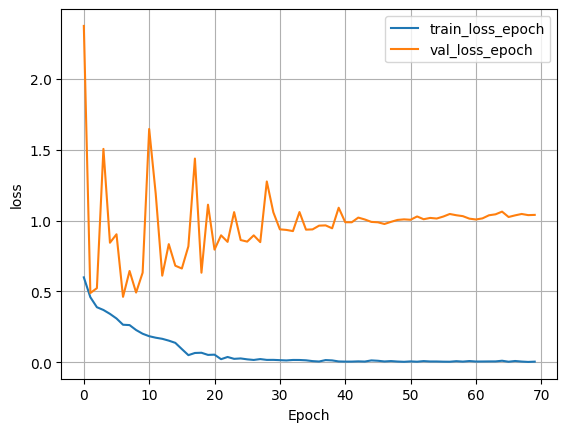

In [26]:
model_manager = train_model(70, 0.2, 0.000012, 0.0032, use_positional_encoder=[False, False, False])

In [27]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def calculatge_metrics(chpt_path, target_data_loader):
    
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=0.2,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=0.2, num_out_features=len(class_id))
    
    classifier_torch_model.load_state_dict(torch.load(chpt_path, weights_only=True, map_location="cuda:0"))
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                    num_classes=len(class_id),
                                            batch_size=batch_size,
                                            user_lr_scheduler=True
                                            ).to(device).eval()
    
    mean_infer_acc = []
    mean_infer_f1 = []
    mean_infer_prec = []
    mean_infer_rec = []
    for i in range(5):
        all_ys = []
        all_y_preds = []
        for X, y in target_data_loader:
            with torch.no_grad():
                y_pred = classfier_lightning_model(X.to(device))
            all_ys.append(torch.argmax(y,dim=1))
            all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
        all_ys = torch.concat(all_ys)
        all_y_preds = torch.concat(all_y_preds)
        
        cm = confusion_matrix(all_ys, all_y_preds, labels=list(id_class.keys()))
        
        accuracy = np.sum(np.diag(cm))/ np.sum(cm)
        precision = np.mean(np.diag(cm) / (np.sum(cm, axis=0)+0.000001))
        recall = np.mean(np.diag(cm) / (np.sum(cm, axis=1)+0.000001))
        f1_score = (2*precision*recall)/(precision + recall+0.000001)
        
        mean_infer_acc.append(accuracy)
        mean_infer_f1.append(f1_score)
        mean_infer_prec.append(precision)
        mean_infer_rec.append(recall)
    mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
    mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
    mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
    mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
    return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model

In [28]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [29]:
def calculate_average_metrics_mean(base_path = 'logs\CNN-GNN18_mr2k_seeds', start=0, interval=1):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []
    
    for i in range(start, start + interval):
        version_path = join(base_path, f'version_{i}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        print(onlyfiles[best_chpt_id])
        mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec, classfier_lightning_model = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader)
            
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)
        total_loss.append(loss)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')
    return classfier_lightning_model

In [31]:
classfier_lightning_model = calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False', start=22)

epoch=27-step=1120.pth


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


total_accuracy: 0.844375
total_f1: 0.8443766098241637
total_prec: 0.8443736205825403
total_rec: 0.844380599101893
total_loss: 0.8474971652030945


In [ ]:
classfier_lightning_model

DataBatch(x=[100642], token_positions=[18859], character_length=[64], num_tokens=[64], token_indices=[100642], token_lengths=[18859], token_embeddings=[18859, 64], token_sentiments=[18859, 2], token_subsampling_probabilities=[18859], batch=[100642], ptr=[65], cumulative_token_indices=[100642])